In [4]:
import numpy as np # computing
from numpy import linalg as LA # linear algebra
from scipy.integrate import odeint # ordinary differential equations
from scipy.linalg import expm # matrix exponentiation
import matplotlib.pyplot as plt # plots
import seaborn as sns # plots

t = np.arange(5000) # hr

# volume
v = np.array([600, 300, 3000, 6000]) # L

# "hollow" flow matrix. row = sink, column = source
Qh = np.array([[0,  2, 0, 6],
               [8,  0, 4, 0],
               [0, 10, 0, 2],
               [0,  0, 8, 0]]) # L/hr

# complete flow matrix. diagonal entries set so columns (axis = 0) sum to zero
Q = Qh - np.diag(Qh.sum(axis = 0)) # L/hr

# plot settings
sns.set(rc={"figure.dpi":200, 'savefig.dpi':300})

# initial concentration [PO4]
P0 = [3, 2, 4, 2] # umol/L

# default plot settings
def legend():
    plt.legend(title="Tank", labels=("A","B","C","D"))

def sys_phys(c, t): # a function of c (could also depend on time) 
    return Q @ c / v # compute c' = f(c)

# Analytical Solution via Matrix Exponentiation

It's worth investigating how well our model has actually performed so we can evaluate the solution it produced. To do this, we need to examine the basic procedural steps the computer followed thus far. First, we started with an initial condition. Then, the computer used the function we defined to compute how that initial condition should be changing at the first moment. Then, it adjusts the initial condition in exactly that direction, while taking a corresponding small step forward in time. Now we have a new condition, from which we compute the rate of change, take a step in that direction, and so on. Needless to say, it would be prohibitively difficult to do this by hand to compute all the way to 5000 model hours. But the computer can do it in less than a second.

What was just described is called a _numerical_ solution because it arises from brute force numerical computations. One benefit of this method is that essentially any system for which _rates_ can be expressed in terms of _states_ can be solved using this method. A potential drawback is that it necessarily breaks up continuous time intervals into discrete steps, so the final calculation will be an approximate, rather than exact solution.

By contrast, it is sometimes possible to find an _exact_ (also known as "analytical") solution using calculus. Rather than computing $\mathbf{c} = g(t)$ as a list of $(\mathbf{c}, t)$ pairs, we determine $g(t)$ as an explicit function like a polynomial, exponential, trig., etc. Our first pass turns out to be one of a special class of systems for which an analytical solution is known. Those will some calculus background may recall that one important property of the exponential functions is that they are proportional to their own derivatives. In particular, the number $e$ can be defined as the unique number for which:

$$\frac{d}{dt}\left[e^t\right] = e^t.$$

And by the chain rule, for any constant $a$:

$$\frac{d}{dt}\left[e^{at}\right] = ae^{at}.$$

One reason we care about this property is that a wide array of physical systems change at a _rate_ proportional to their _state_. For example, it would be reasonable to expect that a 2 kg lump of radioactive $^{235}\text U$ is in some sense twice as dangerous as a 1 kg lump of the same material. Why? Radioactive decay occurs when an atom turns into some other atom, radiating high-energy particles in the process. In terms of hazards, we probably care more about those high-energy particles, but from a modelers perspective, we're more interested in the transformation of atoms into other atoms. Specifically, a "parent" like $^{235}\text U$ decays into a "daughter" ($^{231}\text {Th}$). Every time a decay event happens, the amount of parent decreases. And when twice as much parent is present, that decay occurs twice as fast. Since we tend to find a _lot_ of atoms in something like a 2 kg lump, we can model the amount of parent as a continuous variable, rather than focus on exact numbers of atoms. To sum up, we want to define a continuous variable $P$ as the amount of parent, which decays at a rate proportional to itself. Here's how to write that as a differential equation:

$$P' = -\lambda P.$$

$\lambda$ is the proportionality constant which is specific to each radioactive element. Now, as always, we are looking to perform the transformation:

$$P' = f(P) \longrightarrow P = g(t).$$

But instead of letting the computer do this numerically, we can use our knowledge of exponential functions to solve this system analytically. Since exponential functions are exactly those which are proportional to their own derivative, we can write:

$$P = g(t) = e^{-\lambda t}$$

and check that it indeed solves the differential equation:

$$P' = \frac{d}{dt}\left[e^{-\lambda t}\right] = -\lambda \underbrace{e^{-\lambda t}}_P = -\lambda P.$$

Here we should pause and check whether our model reflects reality. We have performed the transformation and solved for $P = g(t)$. We have found a single function which solves the differential equation, but let's translate this back into reality. Can we predict the amount of parent element remaining at some time in the future with a single function? To return to the original question, will our single equation work for both the 1 kg lump and the 2 kg lump? No, the big lump is clearly going to have more than the small lump, even if we wait a few minutes! We want to be able to model both lumps, so we will need a family of equations $g(t)$ rather than a single one. The way to do this is to scale the entire function by some initial condition $P_0$, the amount at $t = 0$. Here's how to do that:

$$P = g(t) = P_0 e^{-\lambda t}.$$

Let's check that this function still solves the differential equation for any choice of $P_0$:

$$P' = \frac{d}{dt}\left[P_0 e^{-\lambda t}\right] = -\lambda \underbrace{P_0 e^{-\lambda t}}_P = -\lambda P.$$

This is why radioactive elements, among many other physical systems, are said to be governed by "exponential decay." Now, it's time to build on this analytical solution to address the problem at hand, four interconnected tanks. Let's revisit our first model of physical circulation, which we described using the multivariable system:

$$\mathbf{c}' = (Q\mathbf{c})/\mathbf{v}.$$

Notice, there are some similarites with the equation $P' = -\lambda P$ we just analyzed. In both cases, we have the variable _rate_ expressed as a product of the variable _state_ and a constant. In the first case, that constant was just a number, but here it is a matrix. And of course the variable is now a vector instead of a single number. We also have that $/\mathbf{v}$ term at the end. In fact, to really ensure the two cases are perfectly analogous, we should divide each row of $Q$ with the corresponding entry of $\mathbf{v}$; that will define a new matrix which we can call $A$. Then we have:

$$\mathbf{c}' = A\mathbf{c}.$$

If we recall the single variable case above, our transformation eventually yielded the general solution:

$$P' = -\lambda P \longrightarrow \boxed{P = P_0 e^{-\lambda t}.}$$

Perhaps we choose to ignore all the obvious reasons why such an expression makes no sense, and simply rewrite the transformation with our new multivariable system:

$$\mathbf{c}' = A\mathbf{c} \longrightarrow \boxed{\mathbf{c} = \mathbf{c}_0 e^{At}.}$$

We could even define this system in python! Perhaps after a few error messages and some googling, we find a special command "expm" for putting matrices into exponents (people are actually doing this?) and we realize that we actually need to multiply our initial condition vector (P0) on the right, not the left. And maybe we learn how to assign this value, whatever it is, to every $t$ in our interval. Why not plot the result too, just for fun?

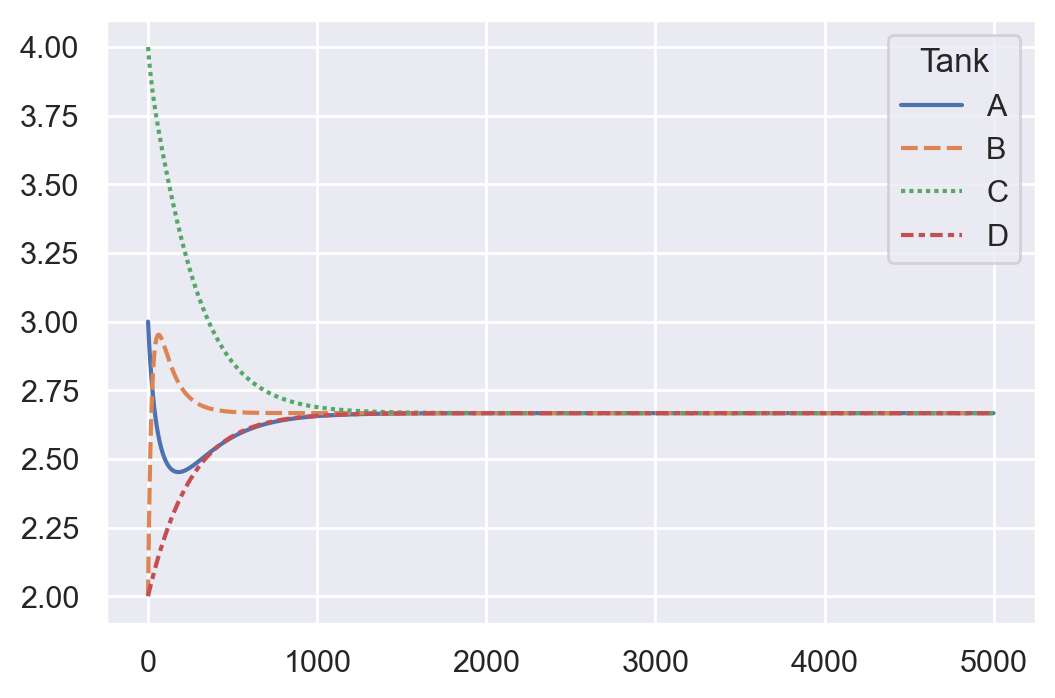

In [3]:
A = (Q.T / v).T # divide each row of Q by entry in v

sol_phys_exact = np.array([expm(A * t) @ P0 for t in t])

sns.lineplot(data=sol_phys_exact)
legend()